In [42]:
import krakenex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from requests.exceptions import HTTPError

In [301]:
kraken = krakenex.API()

In [524]:
def get_order_book(pair, count):
    """Queries the kraken order book.

    Parameters
    ----------
    pair : str 
        Asset pair to get market depth for.
    count : int 
        Maximum number of asks/bids

    Returns
    -------
    dataframe
        Order book as dataframe with columns price, volume, timestamp, type, cumvolume, relprice.
    """
    
    try:
        response = kraken.query_public('Depth', {'pair': pair, 'count': count})
    except HTTPError as e:
        print("ERROR: Failed getting order book data for pair={}".format(pair))
    
    obook = response.get('result', {}).get(pair)
    if not obook:
        print("WARNING: Empty response.")
    else:
        # add cumvolume
        asks = [limorder + ['ask'] for limorder in obook['asks']]
        bids = [limorder + ['bid'] for limorder in obook['bids']]
        tabular = asks + bids
        obook = pd.DataFrame(tabular, columns=['price', 'volume', 'timestamp', 'type'])            
        obook = obook.apply(pd.to_numeric, errors='ignore')
        obook['cumvolume'] = obook[['type', 'volume']].groupby('type').cumsum()  # assumes rows are sorted
        
        # add relprice
        minask = obook.loc[obook['type'] == 'ask', 'price'].min()
        maxbid = obook.loc[obook['type'] == 'bid', 'price'].max()
        spread = minask - maxbid
        midprice = (minask + maxbid) / 2
        obook['relprice'] = 100 * (obook['price'] - midprice) / midprice
        
    return obook


def plot_order_book(ob):
    """Plots the cumulative volume and order distribution of the order book.
    
    Paramaters
    ----------
    ob : dataframe
        Order book data frame with columns type, price, volume, cumvolume, relprice.
    """
    
    # extract data series from df
    ask_prices = ob.loc[ob['type'] == 'ask', 'price']
    ask_relprices = ob.loc[ob['type'] == 'ask', 'relprice']
    ask_volumes = ob.loc[ob['type'] == 'ask', 'volume']
    ask_cumvolumes = ob.loc[ob['type'] == 'ask', 'cumvolume']
    bid_prices = ob.loc[ob['type'] == 'bid', 'price']
    bid_relprices = ob.loc[ob['type'] == 'bid', 'relprice']
    bid_volumes = ob.loc[ob['type'] == 'bid', 'volume']
    bid_cumvolumes = ob.loc[ob['type'] == 'bid', 'cumvolume']
    
    # plot cum vol plot
    fig, ax = plt.subplots(2, 1, figsize=(16, 10))  # sharex='col'
    ax[0].fill_between(bid_relprices, bid_cumvolumes, facecolor='maroon', edgecolor='k', alpha=0.7, zorder=10, label='bids')
    ax[0].fill_between(ask_relprices, ask_cumvolumes, facecolor='dimgrey', edgecolor='k', alpha=0.7, zorder=10, label='asks')
    ax[0].set_xlim([min(bid_relprices.min(), ask_relprices.min()), max(bid_relprices.max(), ask_relprices.max())])
    ax[0].set_ylim([0, 1.05* max(bid_cumvolumes.max(), ask_cumvolumes.max())])
    ax[0].set_xlabel('Distance to midprice (%)')
    ax[0].set_ylabel('Cumulative Volume')
    ax[0].legend(loc='upper center', facecolor='white', framealpha=1, frameon=False)
    
    # plot order distribution
    ax[1].stem(bid_prices, bid_volumes, 'maroon', markerfmt=' ', label='bids')
    ax[1].stem(ask_prices, ask_volumes, 'k', markerfmt=' ', label='asks')
    ax[1].set_ylim([0, 1.05* max(bid_volumes.max(), ask_volumes.max())])
    ax[1].set_xlabel('Price')
    ax[1].set_ylabel('Volume')
    
    plt.show()

In [530]:
N = 200
ob = get_order_book('XXRPZEUR', N)
ob.head()

,price,volume,timestamp,type,cumvolume,relprice
0,0.27519,2375.871,1553289732,ask,2375.871,0.034534
1,0.27531,3900.636,1553289743,ask,6276.507,0.078155
2,0.27532,9653.581,1553289742,ask,15930.088,0.081790
3,0.27534,3493.477,1553289736,ask,19423.565,0.089060
4,0.27536,4500.000,1553289718,ask,23923.565,0.096330


In [531]:
# How much information can we take out while still maintaining the shape of the order book?
threshold = ob.volume.nlargest(int(0.6 * N)).min()
ob_sub = ob.groupby('type').apply(lambda x: x[x['volume'] > threshold])

In [532]:
ob_sub.shape

(119, 6)

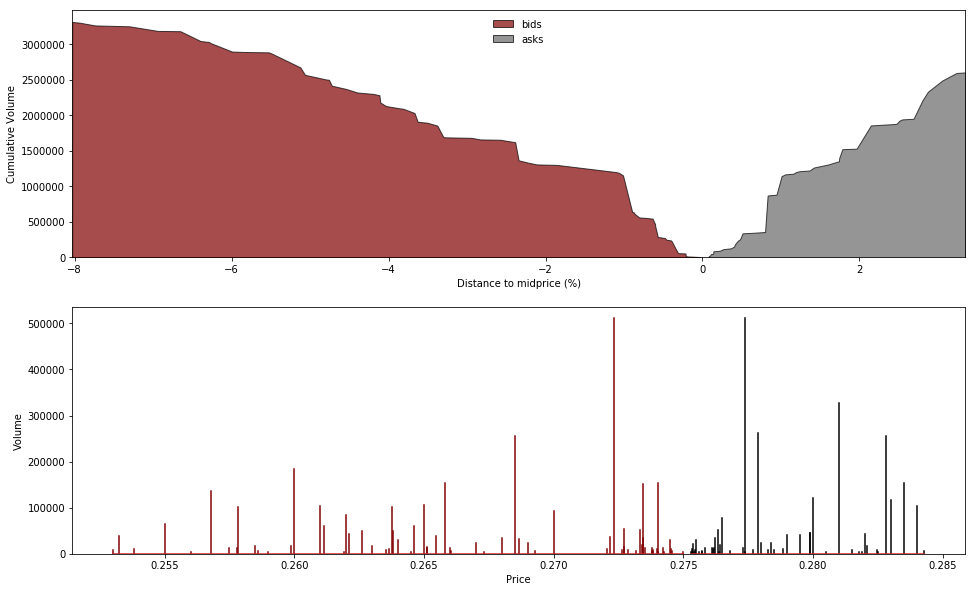

In [533]:
plot_order_book(ob_sub)

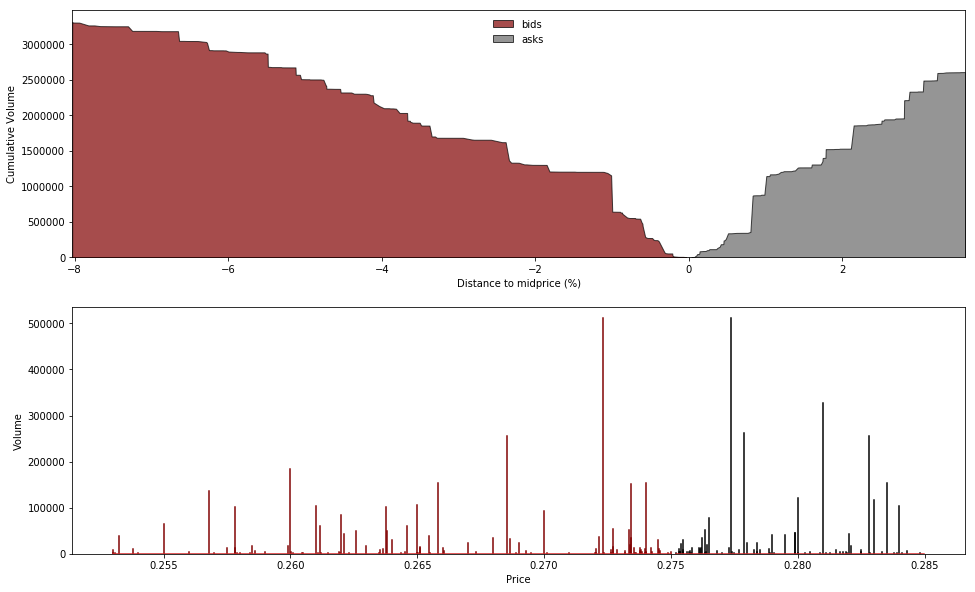

In [534]:
plot_order_book(ob)

In [385]:
def cash_in_orderbook(midpoint, diff, ob):
    """A measure of the relative money needed to move the price from the midprice given the current orders. 
    
    Note that this is normalized by the area of +/- diff about the midprice.

    midprice: float 
        The midpoint of the spread.
    diff : float
        The relative amount in percentage terms you want the price to move from the midpoint.
    ob : dataframe
        The orderbook dataframe or ask / bid dataframe.
    """
    
    oneside = ob[np.less_equal(np.absolute(ob['relprice']), abs(diff)) & (np.sign(ob['relprice']) == np.sign(diff))]
    bothsides = ob[np.less_equal(np.absolute(ob['relprice']), abs(diff))]
    onesidemoney = np.sum(oneside['price'] * oneside['volume'])
    totalmoney = np.sum(bothsides['price'] * bothsides['volume'])
    
    return onesidemoney / totalmoney


def ask_to_total_fraction(ob, ub, n=100):
    """Metric to calculate a series of relative strength of ask vs bid side.
    
    Basically the price weighted order volume on the ask side over the total price weighted order 
    volume within x% of midprice. Returns a series of these at different x%s.
    
    Definition
    ----------
        A / (A + B), where
        A = sum(volume_i * price_i) for the ith order in the ask side between the midprice and the upper bound,
        B = similar metric just for bids.
    
    Parameters
    ----------
    ob : dataframe
        The orderbook with buy and ask orders.
    ub : float
        The relative price upper bound in percent difference from the midpoint.
        
    Returns
    -------
    prices : array
        A linear space of prices.
    metric : array
        The metric calculated at each price point.
    """
    
    asks = ob[ob['type'] == 'ask']
    bids = ob[ob['type'] == 'bid']
    minask = asks.price.min()
    maxbid = bids.price.max()
    
    spread = minask - maxbid
    midprice = (minask + maxbid) / 2
    lb = max(asks.relprice.min(), abs(bids.relprice.max()))  # lower bound
    prices = np.linspace(lb, ub, n)
    metrics = [cash_in_orderbook(midprice, p, ob) for p in prices]
    
    return prices, metrics


def summarize_order_book(ob):
    
    asks = ob[ob['type'] == 'ask']
    bids = ob[ob['type'] == 'bid']
    minask = asks.price.min()
    maxbid = bids.price.max()
    
    spread = minask - maxbid
    midprice = (minask + maxbid) / 2
    spreadperc = 100 * spread / midprice
    
    # first cliff detection
    # define fc as largest vol order within delta% of midpoint
    fc_bounds = 2.0  # percent
    fc_ask = asks.loc[asks.loc[asks['relprice'] > fc_bounds, 'volume'].idxmax()]
    fc_bid = bids.loc[bids.loc[bids['relprice'] > -fc_bounds, 'volume'].idxmax()]
    
    # size of first cliff
    # define sfc as sum of volumes of orders within epsilon% of cliff
    sfc_bounds = 0.1  # percent
    sfc_ask = asks.loc[np.absolute(asks['relprice'] - fc_ask['relprice']) < sfc_bounds, 'volume'].sum()
    sfc_bid = bids.loc[np.absolute(bids['relprice'] - fc_bid['relprice']) < sfc_bounds, 'volume'].sum()
    
    # TODO:
#     Money / volume needed to move price to first cliff edge
#     Money / volume needed to move price to nth interval of first cliff edge
#     USD?
#     divide ask by bids or vice versa to see who has the relative upper hand against percent move from midprice
    
    return midprice, spread, spreadperc

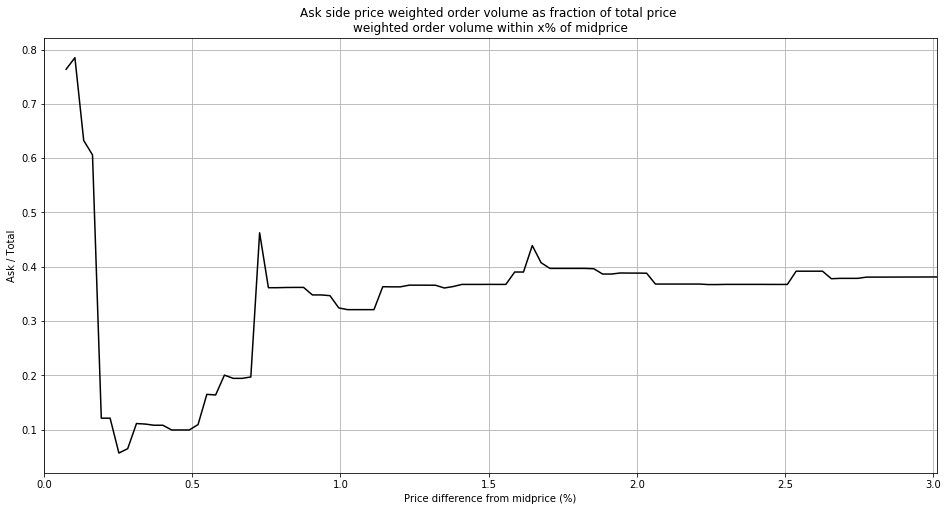

In [384]:
prices, ask = ask_to_total_fraction(ob, np.absolute(ob['relprice']).max())
fig, ax = plt.subplots(figsize=(16, 8))  # sharex='col'
ax.plot(prices, y, 'k')
ax.set_xlim([0, max(x)])
ax.set_title('Ask side price weighted order volume as fraction of total price \nweighted order volume within x% of midprice')
ax.set_xlabel('Price difference from midprice (%)')
ax.set_ylabel('Ask / Total')
ax.grid()

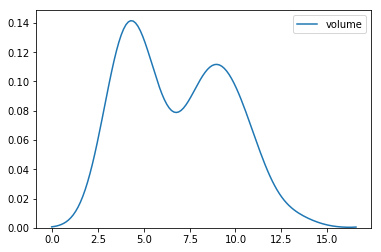

In [121]:
sns.kdeplot(np.log(ob.volume));

In [60]:
np.exp(6.5)

665.1416330443618